In [1]:
%pip install plotly --quiet
%pip install pandas --quiet
%pip install ta --quiet
import ta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
import json
import pandas as pd
import numpy as np
import time

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Use free ProtonVPN. Download bulk binance data here when needed. 
# ****DO NOT RUN UNLESS YOU WANT TO DOWNLOAD NEW DATA****
# ****DO NOT RUN UNLESS YOU WANT TO DOWNLOAD NEW DATA****
# ****DO NOT RUN UNLESS YOU WANT TO DOWNLOAD NEW DATA****
# ****DO NOT RUN UNLESS YOU WANT TO DOWNLOAD NEW DATA****
# ****DO NOT RUN UNLESS YOU WANT TO DOWNLOAD NEW DATA****

interval = '5m'
symbol = 'ETHUSDT'
limit = 1000
# number of: (months * days * hours * minutes * seconds) * miliseconds. Right now this is 30 months of data.
start_time = int((time.time() - 30 * 30 * 24 * 60 * 60) * 1000)
candle_data = []

while True:
    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}&startTime={start_time}'
    request = requests.get(url)
    data = request.json()

    if len(data) == 0:  
        break

    candle_data += data
    start_time = data[-1][0] + 1
    time.sleep(0.1)

with open(f'{symbol}.json', 'w') as f:
    json.dump(candle_data, f)

df = pd.DataFrame(candle_data, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base', 'Taker buy quote', 'Ignore'])
df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
df['Close time'] = pd.to_datetime(df['Close time'], unit='ms')
df.to_csv(f'{symbol}.csv', index=False)

In [2]:
btc_usdt_df = pd.read_csv('BTCUSDT.csv')
eth_usdt_df = pd.read_csv('ETHUSDT.csv')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

dataframes = [btc_usdt_df, eth_usdt_df]

for df in dataframes:
    df.columns = map(str.lower, df.columns)
    df.drop(['close time', 'volume', 'taker buy base', 'taker buy quote', 'ignore'], axis=1, inplace=True)
    df.rename(columns={'quote asset volume': 'volume_usd', 'number of trades': 'num_trades', 'open time': 'time'}, inplace=True)
    df['time'] = pd.to_datetime(df['time'])
    df['atr'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=14)
    df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    df['sma50'] = ta.trend.sma_indicator(df['close'], window=50)
    df['sma100'] = ta.trend.sma_indicator(df['close'], window=100)
    df['sma200'] = ta.trend.sma_indicator(df['close'], window=200)
    df['date'] = df['time'].dt.date
    df['vwap'] = df.groupby('date').apply(lambda x: (x['close'] * x['volume_usd']).cumsum() / x['volume_usd'].cumsum()).reset_index(level=0, drop=True)
    df.drop('date', axis=1, inplace=True)
    df['hlc_3'] = (df['high'] + df['low'] + df['close'])/3
    df['dist_to_sma50'] = df['hlc_3'] - df['sma50']
    df['dist_to_sma100'] = df['hlc_3'] - df['sma100']
    df['dist_to_sma200'] = df['hlc_3'] - df['sma200']
    df['dist_to_vwap'] = df['hlc_3'] - df['vwap']
    df[['atr', 'rsi', 'sma50', 'sma100','sma200']] = df[['atr', 'rsi', 'sma50', 'sma100','sma200']].round(2)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

In [3]:
# Don't want to use whole 250k rows while testing code.
btc_usdt_df = btc_usdt_df.head(20000)
btc_usdt_df

time      open      high       low     close  \
0     2020-12-17 06:10:00  22132.26  22133.35  22053.00  22089.95   
1     2020-12-17 06:15:00  22089.95  22136.59  22063.81  22133.99   
2     2020-12-17 06:20:00  22134.00  22230.00  22113.00  22230.00   
3     2020-12-17 06:25:00  22229.99  22271.45  22190.00  22269.14   
4     2020-12-17 06:30:00  22269.15  22400.00  22099.55  22111.57   
...                   ...       ...       ...       ...       ...   
19995 2021-02-24 22:50:00  48675.75  48824.02  48671.74  48819.00   
19996 2021-02-24 22:55:00  48819.00  48900.00  48700.00  48811.63   
19997 2021-02-24 23:00:00  48811.63  49252.42  48722.71  49150.04   
19998 2021-02-24 23:05:00  49143.32  49505.16  49138.20  49401.74   
19999 2021-02-24 23:10:00  49401.74  49417.83  49200.00  49351.71   

         volume_usd  num_trades     atr    rsi     sma50    sma100    sma200  \
0      9.270872e+06        6276   87.82  58.28  21907.20  21660.13  21168.37   
1      5.376863e+06        4869   86.74  60.88  21915.80  21669.54  21179.80   
2      1.160161e+07        7891   88.90  65.88  21924.50  21678.81  21189.80   
3      9.205871e+06        7432   88.37  67.70  21933.54  21688.38  21199.92   
4      3.789862e+07       17642  103.52  55.02  21938.49  21696.47  21208.82   
...             ...         ...     ...    ...       ...       ...       ...   
19995  1.016909e+07        4099  300.06  54.23  48832.98  49189.00  49750.44   
19996  1.559754e+07        5381  292.91  54.06  48812.82  49183.70  49745.95   
19997  1.412259e+07        7826  309.82  60.40  48802.60  49187.46  49741.12   
19998  2.031282e+07       10110  313.90  64.34  48799.24  49189.59  49739.79   
19999  8.426679e+06        5368  307.04  63.00  48794.76  49192.69  49737.42   

               vwap         hlc_3  dist_to_sma50  dist_to_sma100  \
0      21807.137986  22092.100000     184.899400      431.969300   
1      21809.427128  22111.463333     195.659133      441.920533   
2      21815.688049  22191.000000     266.502200      512.186900   
3      21820.981937  22243.530000     309.989200      555.152100   
4      21834.307722  22203.706667     265.212267      507.237767   
...             ...           ...            ...             ...   
19995  49802.994557  48771.586667     -61.398333     -417.415833   
19996  49799.504294  48803.876667      -8.940533     -379.826933   
19997  49797.440550  49041.723333     239.119133     -145.734967   
19998  49795.640258  49348.366667     549.127667      158.773967   
19999  49794.803966  49323.180000     528.421400      130.485500   

       dist_to_sma200  dist_to_vwap  
0          923.731900    284.962014  
1          931.659383    302.036206  
2         1001.197900    375.311951  
3         1043.610350    422.548063  
4          994.883867    369.398945  
...               ...           ...  
19995     -978.856283  -1031.407890  
19996     -942.068733   -995.627627  
19997     -699.395167   -755.717216  
19998     -391.425883   -447.273592  
19999     -414.239050   -471.623966  

[20000 rows x 18 columns]

In [8]:
########### find_horizontal_resistance_lines ###########

#--> Identifies an "origin" green candle for resistance line starting point. 
#--> Defines the resistance 'line_price' as a weighted mean of the origin candle's high and close prices. 
# (This is superior to HLC/3 because we are only interested in the high wicks for resistance lines). 
#--> The 'waiting_period' and the 'waiting_candles' is a way to separate 'clumped' candle touches to have min # candles between origin point and 2nd touch. 
#--> Checks the following candles for touch points, using % of atr as wiggle room to define an acceptable range for touch points.
#--> Makes sure there are no overlapping lines during line creation.

########### find_horizontal_resistance_lines ###########

In [4]:
def find_horizontal_resistance_lines(df):
    resistance_lines = []
    i = 0
    waiting_period = 10

    # Start a loop over the DataFrame, leaving space for checking a waiting period.
    while i < len(df) - waiting_period: 
        origin_candle = df.iloc[i]

        # Only consider green candles as potential origin points. Could also consider red ones and pick max of 'close', 'open', but isn't as clean.
        if origin_candle['close'] > origin_candle['open']:
            # Define line price as weighted mean of close and high. Set 'second_touch' flag to None.
            line_price = 0.6 * origin_candle['close'] + 0.4 * origin_candle['high'] 
            second_touch = None 

            # Define an acceptable range for the waiting candles. Uses 'atr' of current iterated candle. 
            waiting_candles = df.iloc[i+1:i+waiting_period+1]
            waiting_candles_upper_range = line_price + (0.5 * waiting_candles['atr'])
            waiting_candles_line_price = 0.6 * waiting_candles[['close', 'open']].max(axis=1) + 0.4 * waiting_candles['high']
            
            # Skip to the next 'origin' candle if any waiting candle's close prices exceed the upper limit.
            if any(waiting_candles_line_price > waiting_candles_upper_range):
                i += 1
                continue

            # If all waiting candles are within the range, start looking for the second touch point. Uses 'atr' of current iterated candle.   
            for j in range(i+waiting_period, len(df)):  
                candle = df.iloc[j]

                # Define the upper and lower acceptable touch ranges for the next candle. 
                # 'bottom_limit' is useful for if the price goes way below resistance line, stop the line.
                upper_range = line_price + (0.5 * candle['atr'])
                lower_range = line_price - (0.5 * candle['atr'])
                bottom_limit = line_price - (5 * candle['atr'])

                # 'candle' are the candles when looking for the 2nd touch point.
                # 'bottom' refers to the weighted line price we are going to use when looking for if the 'bottom_limit' gets hit.
                candle_line_price = 0.6 * candle[['close', 'open']].max() + 0.4 * candle['high']
                candle_line_price_bottom = 0.6 * candle[['close', 'open']].min() + 0.4 * candle['low']

                # Check if the candle is a touch point.
                if lower_range <= candle_line_price <= upper_range and second_touch is None:
                    second_touch = candle['time']
                    touch_2_price = candle_line_price
                
                # Check if the candle is outside of the acceptable range or bottom_limit
                if candle_line_price > upper_range or candle_line_price_bottom < bottom_limit:
                    # If there was a second touch, save the line to the list of resistance lines.
                    if second_touch is not None:
                        resistance_lines.append({'initial_point': origin_candle['time'], 'end_of_line': candle['time'], 'touch_2': second_touch, 'touch_2_price': touch_2_price, 'line_price': line_price})
                    second_touch = None  
                    i = j + 1  # Start analyzing from the next candle
                    break
            else:
                i += 1  # If the loop finishes without breaking, check the next candle.
        else:
            i += 1  # If the candle is not green, check the next one.

    return pd.DataFrame(resistance_lines)

resistance_df = find_horizontal_resistance_lines(btc_usdt_df)

In [5]:
time_interval_in_minutes = 5
resistance_df['initial_point'] = pd.to_datetime(resistance_df['initial_point'])
resistance_df['end_of_line'] = pd.to_datetime(resistance_df['end_of_line'])

# Calculates length of horizontal resistance line based on time interval. Returns # of candles as a value.
resistance_df['line_length'] = (resistance_df['end_of_line'] - resistance_df['initial_point']).dt.total_seconds() / (time_interval_in_minutes * 60)
resistance_df['line_length'] = resistance_df['line_length'].astype(int)

In [6]:
resistance_df

initial_point         end_of_line             touch_2  \
0   2020-12-17 06:25:00 2020-12-17 07:20:00 2020-12-17 07:15:00   
1   2020-12-17 09:25:00 2020-12-17 13:05:00 2020-12-17 12:55:00   
2   2020-12-17 13:35:00 2020-12-17 16:05:00 2020-12-17 15:50:00   
3   2020-12-17 16:30:00 2020-12-17 18:15:00 2020-12-17 17:20:00   
4   2020-12-17 20:50:00 2020-12-17 22:00:00 2020-12-17 21:40:00   
..                  ...                 ...                 ...   
375 2021-02-24 02:00:00 2021-02-24 03:45:00 2021-02-24 02:50:00   
376 2021-02-24 04:05:00 2021-02-24 13:30:00 2021-02-24 09:35:00   
377 2021-02-24 13:45:00 2021-02-24 16:00:00 2021-02-24 15:55:00   
378 2021-02-24 16:35:00 2021-02-24 17:55:00 2021-02-24 17:25:00   
379 2021-02-24 21:55:00 2021-02-24 23:00:00 2021-02-24 22:45:00   

     touch_2_price  line_price  line_length  
0        22288.760   22270.064           11  
1        23169.594   23162.428           44  
2        23270.470   23326.852           30  
3        23587.012   23642.482           21  
4        22696.168   22721.138           14  
..             ...         ...          ...  
375      50349.864   50533.200           21  
376      51188.258   51152.534          113  
377      49831.700   49760.218           27  
378      49865.160   49756.854           16  
379      48704.332   48789.940           13  

[380 rows x 6 columns]

In [7]:
########### find_touch_points ###########

#--> After the initial two points of a resistance line are established, this function finds further touch points.
#--> Utilizes a 'waiting_period' to ensure some distance between subsequent touch points, preventing clumping.
#--> Defines the acceptable range for touch points using a % of atr as a threshold. Checks the df for touch points within this range.
#--> If a touch point is found, the function records it's price and timestamp, and starts the search for the next touch point after the waiting period.
#--> If the price moves outside of the acceptable range before another touch point is found, or if the 'bottom_limit' is crossed, the line ends. 
#--> Iterates over the resistance_df until all lines have been evaluated for further touch points.

########### find_touch_points ###########

In [7]:
def find_touch_points(df, resistance_df):

    # Set waiting period between touches, initialize counter for max touch points, initialize list of column names for touch points and prices.
    waiting_period = 10
    max_touch_points = 0
    touch_point_cols = []
    touch_price_cols = []
    
    # Iterate over the resistance lines DataFrame.
    for idx, row in resistance_df.iterrows():
        # Define the start index (just after the second touch point), end index and the resistance line price.
        second_touch_point = row['touch_2']
        price = row['line_price']
        start_idx = df.loc[df['time'] == second_touch_point].index[0] + waiting_period
        end_idx = df.loc[df['time'] == row['end_of_line']].index[0]

        # Initialize dict for touch points and prices.
        touch_points = {}
        touch_prices = {}

        # Loop over the df from the start index to the end index.
        while start_idx < end_idx:
            slice_df = df.iloc[start_idx:end_idx+1]  

            # Initialize a flag for found touch points.
            found = False

            # Loop over each candle within the sliced DataFrame.
            for j, candle in slice_df.iterrows():
                # Define the upper and lower acceptable ranges for touch points.
                # 'bottom_limit' is useful for if the price goes way below resistance line, stop the line.
                upper_range = price + (0.5 * candle['atr'])
                lower_range = price - (0.5 * candle['atr'])
                bottom_limit = price - (5 * candle['atr'])

                candle_line_price = 0.6 * candle[['close', 'open']].max() + 0.4 * candle['high']
                candle_line_price_bottom = 0.6 * candle[['close', 'open']].min() + 0.4 * candle['low']

                # Check if the candle is within the acceptable range for a touch point.
                if lower_range <= candle_line_price <= upper_range:
                    touch_points[len(touch_points)+3] = candle['time']
                    touch_prices[len(touch_prices)+3] = candle_line_price
                    # Start the next search after the waiting period.
                    start_idx = j + waiting_period
                    found = True
                    break
                # Check if the candle is outside of the acceptable range or bottom_limit.
                if candle_line_price > upper_range or candle_line_price_bottom < bottom_limit:
                    break
            # If no touch point was found, break the loop.                
            if not found:
                break

        # Update the maximum number of touch points.
        max_touch_points = max(max_touch_points, len(touch_points))

        # Loops over found touch points and adds them to resistance_df.
        for i, touch_point in touch_points.items():
            # Define column names for touch points and their prices.
            col_name = f'touch_point_{i}'
            price_col_name = f'touch_point_{i}_price'

            # Add new columns (timestamp and price) to the DataFrame if they don't exist.
            if col_name not in touch_point_cols:
                touch_point_cols.append(col_name)
                resistance_df[col_name] = None
            if price_col_name not in touch_price_cols:
                touch_price_cols.append(price_col_name)
                resistance_df[price_col_name] = None

            # Add the touch points (timestamps) and their prices to the df.
            resistance_df.loc[idx, col_name] = touch_point
            resistance_df.loc[idx, price_col_name] = touch_prices[i]
        # Record the total number of touch points for the line in the df.
        resistance_df.loc[idx, 'num_touch_points'] = len(touch_points)

    return resistance_df

resistance_df = find_touch_points(btc_usdt_df, resistance_df)

In [8]:
# Creates 3rd touch boolean for calculating returns later. 
resistance_df['3rd_touch_bool'] = resistance_df['touch_point_3'].notna()
# Every line has minimum of 2 touchpoints already at this point.
resistance_df['num_touch_points'] = resistance_df['num_touch_points'] + 2 
resistance_df['num_touch_points'] = resistance_df['num_touch_points'].astype(int)

In [12]:
########### calculate_trading_results ###########

#--> Calculates the trading results based on returns calculated.
#--> Uses the closing price as the 3rd touch point as the entry point for the trade.
#--> Length of trade is up to 3x length of resistance line.
#--> Defines the stop loss level as 1.3*atr below the entry, and the take profit level as 3*atr above the entry.
#--> Iterates through the sliced data to determine whether the stop loss or take profit was hit first, or neither was hit during the period.
#--> Adds columns to the resistance line DataFrame to store the entry price, stop loss, take profit, the result, timestamp of target hit

########### calculate_trading_results ###########

In [9]:
def calculate_trading_results(df, resistance_df):
    for idx, row in resistance_df.iterrows():
        if not row['3rd_touch_bool']:
            continue

        third_point = row['touch_point_3']

        # Find the index of the third touch point
        third_point_index = df[df['time'] == third_point].index[0]

        # Define the entry price as the opening price at the next candle after the third touch point. 
        entry_price = df.iloc[third_point_index + 1]['open']
        
        # Define the entry time as the time of the next candle after the third touch point.
        entry_time = df.iloc[third_point_index + 1]['time']

        # The slice should start from the next row after the entry_time
        slice_df = df.iloc[third_point_index + 1:]

        result = 'None'
        target_hit_time = 'None'

        # Iterate through the sliced DataFrame to check whether the stop loss or take profit was hit.
        for _, candle in slice_df.iterrows():
            atr = candle['atr']
            sl_level = entry_price - 1.3 * atr
            tp_level = entry_price + 3 * atr

            if candle['high'] >= tp_level:
                result = 'Take Profit'
                target_hit_time = candle['time']
                break
            elif candle['low'] <= sl_level:
                result = 'Stop Loss'
                target_hit_time = candle['time']
                break

        if result == 'None':
            result = 'No Target Hit'

        resistance_df.at[idx, 'entry_price'] = entry_price
        resistance_df.at[idx, 'entry_time'] = entry_time
        resistance_df.at[idx, 'sl'] = sl_level
        resistance_df.at[idx, 'tp'] = tp_level
        resistance_df.at[idx, 'result'] = result
        resistance_df.at[idx, 'target_hit_time'] = target_hit_time

calculate_trading_results(btc_usdt_df, resistance_df)

In [10]:
resistance_df

initial_point         end_of_line             touch_2  \
0   2020-12-17 06:25:00 2020-12-17 07:20:00 2020-12-17 07:15:00   
1   2020-12-17 09:25:00 2020-12-17 13:05:00 2020-12-17 12:55:00   
2   2020-12-17 13:35:00 2020-12-17 16:05:00 2020-12-17 15:50:00   
3   2020-12-17 16:30:00 2020-12-17 18:15:00 2020-12-17 17:20:00   
4   2020-12-17 20:50:00 2020-12-17 22:00:00 2020-12-17 21:40:00   
..                  ...                 ...                 ...   
375 2021-02-24 02:00:00 2021-02-24 03:45:00 2021-02-24 02:50:00   
376 2021-02-24 04:05:00 2021-02-24 13:30:00 2021-02-24 09:35:00   
377 2021-02-24 13:45:00 2021-02-24 16:00:00 2021-02-24 15:55:00   
378 2021-02-24 16:35:00 2021-02-24 17:55:00 2021-02-24 17:25:00   
379 2021-02-24 21:55:00 2021-02-24 23:00:00 2021-02-24 22:45:00   

     touch_2_price  line_price  line_length  num_touch_points  \
0        22288.760   22270.064           11                 2   
1        23169.594   23162.428           44                 2   
2        23270.470   23326.852           30                 2   
3        23587.012   23642.482           21                 2   
4        22696.168   22721.138           14                 2   
..             ...         ...          ...               ...   
375      50349.864   50533.200           21                 3   
376      51188.258   51152.534          113                 3   
377      49831.700   49760.218           27                 2   
378      49865.160   49756.854           16                 2   
379      48704.332   48789.940           13                 2   

           touch_point_3 touch_point_3_price touch_point_4  \
0                   None                None          None   
1                   None                None          None   
2                   None                None          None   
3                   None                None          None   
4                   None                None          None   
..                   ...                 ...           ...   
375  2021-02-24 03:40:00           50527.444          None   
376  2021-02-24 12:20:00           51117.594          None   
377                 None                None          None   
378                 None                None          None   
379                 None                None          None   

    touch_point_4_price touch_point_5 touch_point_5_price touch_point_6  \
0                  None          None                None          None   
1                  None          None                None          None   
2                  None          None                None          None   
3                  None          None                None          None   
4                  None          None                None          None   
..                  ...           ...                 ...           ...   
375                None          None                None          None   
376                None          None                None          None   
377                None          None                None          None   
378                None          None                None          None   
379                None          None                None          None   

    touch_point_6_price touch_point_7 touch_point_7_price  3rd_touch_bool  \
0                  None          None                None           False   
1                  None          None                None           False   
2                  None          None                None           False   
3                  None          None                None           False   
4                  None          None                None           False   
..                  ...           ...                 ...             ...   
375                None          None                None            True   
376                None          None                None            True   
377                None          None                None           False   
378     

In [11]:
resistance_df['touch_point_3'] = pd.to_datetime(resistance_df['touch_point_3'])
resistance_df['target_hit_time'] = pd.to_datetime(resistance_df['target_hit_time'])
# Calculates time in trade using the interval specified earlier. Returns # of candles.
resistance_df['time_in_trade'] = (resistance_df['target_hit_time'] - resistance_df['touch_point_3']).dt.total_seconds() / (time_interval_in_minutes * 60)
resistance_df['time_in_trade'] = resistance_df['time_in_trade'].astype('Int64')
def calculate_target_hit_price(row):
    if row['result'] == 'Take Profit':
        return row['tp']
    elif row['result'] == 'Stop Loss':
        return row['sl']
    else:
        return np.nan
resistance_df['target_hit_price'] = resistance_df.apply(calculate_target_hit_price, axis=1)
resistance_df['pos_size'] = 10000
resistance_df['reward'] = ((resistance_df['tp'] - resistance_df['entry_price'])/resistance_df['entry_price'])
resistance_df['risk'] = ((resistance_df['sl'] - resistance_df['entry_price'])/resistance_df['entry_price'])
resistance_df['rr_ratio'] = abs(resistance_df['reward'] / resistance_df['risk'])
def calculate_pl(row):
    if row['result'] == 'Take Profit':
        return row['pos_size'] * row['reward']
    elif row['result'] == 'Stop Loss':
        return row['pos_size'] * row['risk']
    else:
        return np.nan
resistance_df['fee'] = 0.001 * resistance_df['pos_size']
resistance_df['pl_b4_fee'] = resistance_df.apply(calculate_pl, axis=1)
resistance_df['net_pl_with_fee'] = resistance_df['pl_b4_fee'] - resistance_df['fee']
resistance_df

initial_point         end_of_line             touch_2  \
0   2020-12-17 06:25:00 2020-12-17 07:20:00 2020-12-17 07:15:00   
1   2020-12-17 09:25:00 2020-12-17 13:05:00 2020-12-17 12:55:00   
2   2020-12-17 13:35:00 2020-12-17 16:05:00 2020-12-17 15:50:00   
3   2020-12-17 16:30:00 2020-12-17 18:15:00 2020-12-17 17:20:00   
4   2020-12-17 20:50:00 2020-12-17 22:00:00 2020-12-17 21:40:00   
..                  ...                 ...                 ...   
375 2021-02-24 02:00:00 2021-02-24 03:45:00 2021-02-24 02:50:00   
376 2021-02-24 04:05:00 2021-02-24 13:30:00 2021-02-24 09:35:00   
377 2021-02-24 13:45:00 2021-02-24 16:00:00 2021-02-24 15:55:00   
378 2021-02-24 16:35:00 2021-02-24 17:55:00 2021-02-24 17:25:00   
379 2021-02-24 21:55:00 2021-02-24 23:00:00 2021-02-24 22:45:00   

     touch_2_price  line_price  line_length  num_touch_points  \
0        22288.760   22270.064           11                 2   
1        23169.594   23162.428           44                 2   
2        23270.470   23326.852           30                 2   
3        23587.012   23642.482           21                 2   
4        22696.168   22721.138           14                 2   
..             ...         ...          ...               ...   
375      50349.864   50533.200           21                 3   
376      51188.258   51152.534          113                 3   
377      49831.700   49760.218           27                 2   
378      49865.160   49756.854           16                 2   
379      48704.332   48789.940           13                 2   

          touch_point_3 touch_point_3_price touch_point_4 touch_point_4_price  \
0                   NaT                None          None                None   
1                   NaT                None          None                None   
2                   NaT                None          None                None   
3                   NaT                None          None                None   
4                   NaT                None          None                None   
..                  ...                 ...           ...                 ...   
375 2021-02-24 03:40:00           50527.444          None                None   
376 2021-02-24 12:20:00           51117.594          None                None   
377                 NaT                None          None                None   
378                 NaT                None          None                None   
379                 NaT                None          None                None   

    touch_point_5 touch_point_5_price touch_point_6 touch_point_6_price  \
0            None                None          None                None   
1            None                None          None                None   
2            None                None          None                None   
3            None                None          None                None   
4            None                None          None                None   
..            ...                 ...           ...                 ...   
375          None                None          None                None   
376          None                None          None                None   
377          None                None          None                None   
378          None                None          None                None   
379          None                None          None                None   

    touch_point_7 touch_point_7_price  3rd_touch_bool  entry_price  \
0            None                None           False          NaN   
1            None                None           False          NaN   
2            None                None           False          NaN   
3            None                None           False          NaN   
4            None                None           False          NaN   
..            ...                 ...             ...          ...   
375          None                None            True     50

In [12]:
# Sorting df: (Automatically takes care of N touch points)

# Define the manually ordered columns before and after touch points
manual_cols_before = ['initial_point', 'end_of_line', 'line_price', 'line_length', 'touch_2', 'touch_2_price']
manual_cols_after = ['num_touch_points', '3rd_touch_bool', 'entry_time', 'entry_price', 'sl', 'tp', 'result', 'target_hit_time', 'target_hit_price', 'time_in_trade', 'pos_size', 'reward',	'risk',	'rr_ratio',	'pl_b4_fee', 'fee', 'net_pl_with_fee']
# Extract all columns starting with 'touch_point_' and sort them
touch_cols = sorted([col for col in resistance_df.columns if col.startswith('touch_point_') and col not in manual_cols_before and col not in manual_cols_after])
# Combine all lists while maintaining the desired order
final_cols = manual_cols_before + touch_cols + manual_cols_after
# Reorganize the DataFrame using the new column order
resistance_df = resistance_df[final_cols]

# splits the horizontal line info down to only entries where trades occured
trades_df = resistance_df[resistance_df['entry_price'].notnull()]
trades_df.reset_index(drop=True, inplace=True)
trades_df

initial_point         end_of_line  line_price  line_length  \
0   2020-12-17 22:45:00 2020-12-18 02:15:00   23044.328           42   
1   2020-12-18 17:45:00 2020-12-18 21:00:00   22800.496           39   
2   2020-12-19 00:10:00 2020-12-19 02:30:00   23080.370           28   
3   2020-12-19 10:05:00 2020-12-19 12:35:00   23060.472           30   
4   2020-12-20 11:45:00 2020-12-20 15:25:00   23616.618           44   
..                  ...                 ...         ...          ...   
98  2021-02-22 14:55:00 2021-02-22 20:00:00   53549.046           61   
99  2021-02-23 08:30:00 2021-02-23 13:00:00   48614.434           54   
100 2021-02-23 13:10:00 2021-02-23 18:10:00   49287.922           60   
101 2021-02-24 02:00:00 2021-02-24 03:45:00   50533.200           21   
102 2021-02-24 04:05:00 2021-02-24 13:30:00   51152.534          113   

                touch_2  touch_2_price       touch_point_3  \
0   2020-12-18 01:15:00      22996.666 2020-12-18 02:05:00   
1   2020-12-18 18:45:00      22774.192 2020-12-18 20:00:00   
2   2020-12-19 01:05:00      23058.806 2020-12-19 01:55:00   
3   2020-12-19 11:00:00      23058.158 2020-12-19 12:30:00   
4   2020-12-20 14:15:00      23596.264 2020-12-20 15:05:00   
..                  ...            ...                 ...   
98  2021-02-22 15:45:00      53681.690 2021-02-22 16:35:00   
99  2021-02-23 09:25:00      48459.014 2021-02-23 10:15:00   
100 2021-02-23 14:05:00      49105.566 2021-02-23 15:35:00   
101 2021-02-24 02:50:00      50349.864 2021-02-24 03:40:00   
102 2021-02-24 09:35:00      51188.258 2021-02-24 12:20:00   

    touch_point_3_price        touch_point_4 touch_point_4_price  \
0             23065.744                 None                None   
1             22776.656                 None                None   
2             23056.784                 None                None   
3             23056.586                 None                None   
4             23599.112                 None                None   
..                  ...                  ...                 ...   
98             53766.62  2021-02-22 18:40:00             53425.6   
99            48526.836  2021-02-23 12:35:00           48577.652   
100           48966.568                 None                None   
101           50527.444                 None                None   
102           51117.594                 None                None   

           touch_point_5 touch_point_5_price touch_point_6  \
0                   None                None          None   
1                   None                None          None   
2                   None                None          None   
3                   None                None          None   
4                   None                None          None   
..                   ...                 ...           ...   
98   2021-02-22 19:30:00           53522.294          None   
99                  None                None          None   
100                 None                None          None   
101                 None                None          None   
102                 None                None          None   

    touch_point_6_price touch_point_7 touch_point_7_price  num_touch_points  \
0                  None          None                None                 3   
1                  None          None                None                 3   
2                  None          None                None                 3   
3                  None          None                None                 3   
4                  None          None                None                 3   
..                  ...           ...                 ...               ...   
98                 None          None                None                 5   
99                 None          None                None                 4   
100                None          None                None                 3   
101                None          None           

In [13]:
print('Num touch points avg:', trades_df['num_touch_points'].mean())
print('Num touch points max:', trades_df['num_touch_points'].max())
print('avg trade length # candles:', trades_df['time_in_trade'].mean())
print('max trade length # candles:', trades_df['time_in_trade'].max())
print('min trade length # candles:', trades_df['time_in_trade'].min())
print('mean reward:', trades_df['reward'].mean())
print('mean risk:', trades_df['risk'].mean())
print('avg rr ratio:', trades_df['rr_ratio'].mean())
print('pl total:', trades_df['net_pl_with_fee'].sum())
print('pl avg per trade:', trades_df['net_pl_with_fee'].mean())
print('number of losses:', trades_df['result'].value_counts()['Stop Loss'])
print('number of wins:', trades_df['result'].value_counts()['Take Profit'])
print('Total Trades: ', trades_df['result'].count())
print('win %: ', trades_df['result'].value_counts()['Take Profit']/trades_df['result'].count())
print('loss %: ', trades_df['result'].value_counts()['Stop Loss']/trades_df['result'].count())

Num touch points avg: 3.3009708737864076
Num touch points max: 7
avg trade length # candles: 9.087378640776699
max trade length # candles: 30
min trade length # candles: 1
mean reward: 0.013180972077372718
mean risk: -0.005711754566861508
avg rr ratio: 2.3076923076923097
pl total: 199.86816399099388
pl avg per trade: 1.9404676115630473
number of losses: 61
number of wins: 42
Total Trades:  103
win %:  0.4077669902912621
loss %:  0.5922330097087378


In [10]:
########### calculate_returns_after_third_touch ###########

#--> Calculates the returns after 3rd touch point of a resistance line. Only processes resistance lines that have 3rd touch point.
#--> Uses the closing price at the third touch point as the entry point for the trade.
#--> The data is sliced from the 3rd touch point to the end of a period desired period (3*line_length).
#--> Returns calculated as 'entry_price' - closing candles prices.
#--> The return data is stored in a dictionary indexed by the resistance line ID. 
#--> Good for determining a trading strategy or backtesting/optimizing for SL/TP/etc. (Use bulk data rather than this sample Kraken data)

########### calculate_returns_after_third_touch ###########

In [19]:
def trade_analysis(btc_usdt_df, trades_df):
    analysis_dict = {}

    for idx, row in trades_df.iterrows():

        entry_price = row['entry_price']
        entry_time = row['entry_time']
        
        start_idx = btc_usdt_df.loc[btc_usdt_df['time'] == entry_time].index[0]
        end_idx = min(start_idx + 101, len(btc_usdt_df) - 1)
        slice_df = btc_usdt_df.iloc[start_idx:end_idx]

        trade_df = slice_df[['rsi', 'hlc_3', 'dist_to_sma50', 'dist_to_sma100', 'dist_to_sma200', 'dist_to_vwap', 'num_trades', 'volume_usd']].copy()
        trade_df['returns'] = trade_df['hlc_3'].apply(lambda x: x - entry_price)

        trade_df.drop(columns=['hlc_3'], inplace=True)
        trade_df.reset_index(drop=True, inplace=True)
        trade_df.index = 'e+' + trade_df.index.astype(str)

        analysis_dict[idx] = trade_df

    return analysis_dict

analysis_dict = trade_analysis(btc_usdt_df, trades_df)

# 'e+0' will reflect the price change that happened within the 'entry_time' candle itself. 'e' stands for entry.

In [ ]:
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

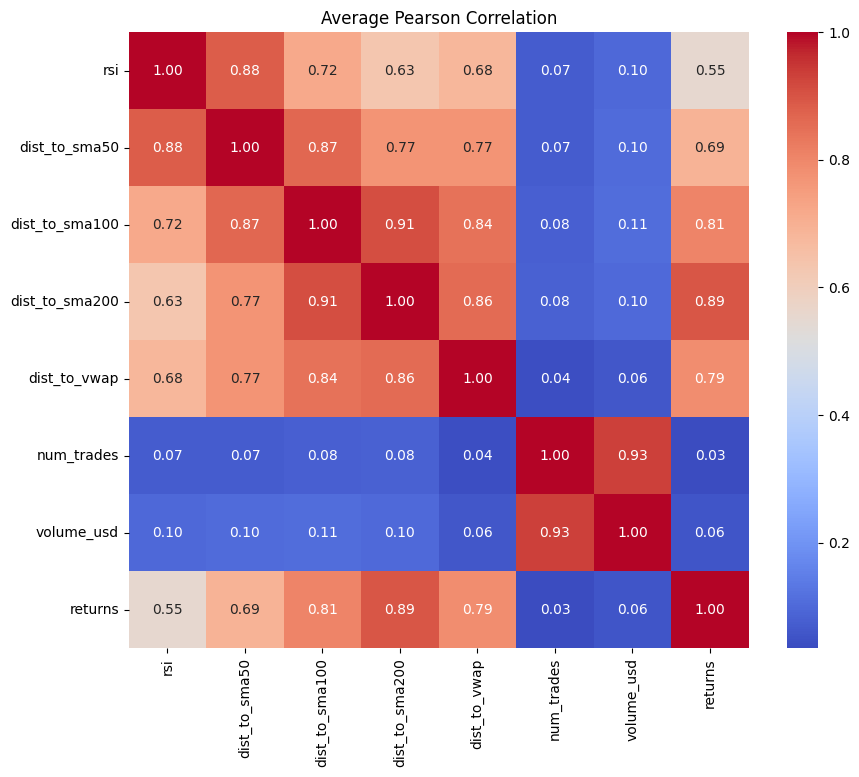

In [29]:
corr_df = pd.DataFrame()

for trade_df in analysis_dict.values():
    corr = trade_df.corr(method='pearson')
    corr_df = corr_df.add(corr, fill_value=0)

corr_df /= len(analysis_dict)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Average Pearson Correlation')
plt.show()

In [24]:
def create_scatter_plots(analysis_dict):
    indicators = ['rsi', 'dist_to_sma50', 'dist_to_sma100', 'dist_to_sma200', 'dist_to_vwap', 'num_trades', 'volume_usd']

    for indicator in indicators:
        fig = go.Figure()

        # Loops over each trade in the analysis_dict
        for trade, trade_df in analysis_dict.items():

            # Adds a scatter trace for 'returns' of each trade
            returns_trace = go.Scatter(x=trade_df.index, y=trade_df['returns'], mode='lines', name=f'Returns Trade {trade}', yaxis='y1', line=dict(color='#FFD700'))
            fig.add_trace(returns_trace)

            # Adds a scatter trace for the current indicator of each trade
            indicator_trace = go.Scatter(x=trade_df.index, y=trade_df[indicator], mode='lines', name=f'{indicator.capitalize()} Trade {trade}', yaxis='y2', line=dict(color='white'), opacity=0.6)
            fig.add_trace(indicator_trace)

        fig.add_hline(y=0, line=dict(color='#39FF14', width=2, dash='dash'))

        fig.update_layout(
            title=f'Returns and {indicator.capitalize()} Over Time',
            xaxis_title="Candles after Entry",
            yaxis=dict(title='Returns', side='left', color='#FFD700'),
            yaxis2=dict(title=indicator.capitalize(), side='right', overlaying='y', color='white'),
            showlegend=False,
            template="plotly_dark"
        )
        fig.show()

create_scatter_plots(analysis_dict)

In [17]:
# Slices the 250,000+ rows of 'btc_usdt_df' so we can plot candlesticks in a more managable chunk.
plt_btc_usdt_df = btc_usdt_df.head(4000)

# Slices resistance_df to match 'plt_btc_usdt_df' length.
last_timestamp = plt_btc_usdt_df['time'].iloc[-1]
mask = resistance_df['end_of_line'] <= last_timestamp
plt_resistance_df = resistance_df[mask]

In [18]:
# Candlestick plot
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Plots candlestick graph with atr, horizontal resistance line, all touch points and target hit point.
candlestick_trace = go.Candlestick(x=plt_btc_usdt_df['time'], open=plt_btc_usdt_df['open'], high=plt_btc_usdt_df['high'], low=plt_btc_usdt_df['low'], close=plt_btc_usdt_df['close'], name='Candlesticks')
atr_trace = go.Scatter(x=plt_btc_usdt_df['time'], y=plt_btc_usdt_df['atr'], mode='lines', name='ATR', line=dict(color='purple'), opacity=0.6)
vwap_trace = go.Scatter(x=plt_btc_usdt_df['time'], y=plt_btc_usdt_df['vwap'], mode='lines', name='VWAP', line=dict(color='white'), opacity=0.6)
first_touch_trace = go.Scatter(x=plt_resistance_df['initial_point'], y=plt_resistance_df['line_price'], mode='markers', name='First Touch Point', marker=dict(color='white', size=6))
second_touch_trace = go.Scatter(x=plt_resistance_df['touch_2'], y=plt_resistance_df['touch_2_price'], mode='markers', name='Second Touch Point', marker=dict(color='white', size=6))
entry_trace = go.Scatter(x=plt_resistance_df['entry_time'], y=plt_resistance_df['entry_price'], mode='markers', name='Entry', marker=dict(color='#FFD700', size=7))
target_trace = go.Scatter(x=plt_resistance_df['target_hit_time'], y=plt_resistance_df['target_hit_price'], mode='markers', name='Target Hit', marker=dict(color='#FFD700', size=7))


fig.add_trace(candlestick_trace, secondary_y=False)
fig.add_trace(first_touch_trace, secondary_y=False)
fig.add_trace(second_touch_trace, secondary_y=False)

# adding multiple touch point traces to the figure starting with 'touch_point_3'.
for i in range(3, len(plt_resistance_df.columns)):
    touch_point_column = 'touch_point_' + str(i)
    touch_price_column = 'touch_point_' + str(i) + '_price'
    # If a column name exists in the df in the format 'touch_point_i', a trace is created for the touch points in that column and added to graph.
    if touch_point_column in plt_resistance_df.columns:
        touch_point_trace = go.Scatter(x=plt_resistance_df[touch_point_column], y=plt_resistance_df[touch_price_column], mode='markers', name=f'Touch Point {i}', marker=dict(color='#B200ED', size=7))
        fig.add_trace(touch_point_trace, secondary_y=False)

fig.add_trace(entry_trace, secondary_y=False)
fig.add_trace(target_trace, secondary_y=False)
fig.add_trace(atr_trace, secondary_y=True)
fig.add_trace(vwap_trace, secondary_y=False)

fig.update_layout(title='BTC/USDT', xaxis_title='Time', template="plotly_dark", legend=dict(y=1.2, font=dict(size=12)))
fig.update_yaxes(title_text='Price', secondary_y=False, tickformat="$,.2f", autorange=True, fixedrange=False)
fig.update_yaxes(title_text='ATR', secondary_y=True)

# Adds the horizontal resistance lines to graph. Iterates through each row of the resistance_df.
for _, row in plt_resistance_df.iterrows():
    start_time = row['initial_point']
    end_time = row['end_of_line']
    price = row['line_price']
    
    fig.add_shape(type="line", x0=start_time, y0=price, x1=end_time, y1=price, line=dict(color='#39FF14', width=2), xref='x', yref='y')

fig.show()